In [1]:
import time
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('dark_background')

In [2]:
def simple_monte_carlo(initial_stock_price, strike_price, time_to_maturity, 
                       risk_free_interest_rate, dividend_rate, 
                       volatility, option_type, time_steps_count, samples_count):
    
    rate_difference = risk_free_interest_rate - dividend_rate
    
    # Stock prices
    
    samples = np.zeros(samples_count) 
    time_step = time_to_maturity/time_steps_count
    
    weights = np.random.standard_normal(size=(samples_count, time_steps_count))
    
    samples = weights.sum(axis=1) * np.sqrt(time_step)  

    stock_prices = initial_stock_price * np.exp((rate_difference - 0.5 * volatility ** 2) * time_to_maturity 
                                                + volatility * samples)
    
    # Option prices
    
    price_differences = stock_prices - strike_price   
    
    if option_type == 'Put':
        price_differences = -price_differences
    
    price_differences[price_differences < 0] = 0
    
    option_prices = price_differences * np.exp(-risk_free_interest_rate * time_to_maturity)
         
    return option_prices

In [16]:
def plot_asset_prices(initial_asset_prices, volatilities, asset_prices_meshgrid,
                       elevation=10, initial_azimuth=230):

    initial_asset_prices_grid, volatilities_grid = np.meshgrid(initial_asset_prices, volatilities)

    fig, ax = plt.subplots(figsize=(5, 5),
                           subplot_kw={"projection": "3d"})

    surface = ax.plot_surface(initial_asset_prices_grid,
                              volatilities_grid,
                              asset_prices_meshgrid.T,
                              cmap='plasma',
                              linewidth=30, 
                              antialiased=False)

    ax.view_init(elev=elevation, azim=initial_azimuth)

    ax.zaxis.set_rotate_label(False)
    
    ax.set_xlabel('Initial Asset Price')
    ax.set_ylabel('Volatility')
    ax.set_zlabel('Asset Price', rotation=90)
    
    plt.show()

In [17]:
# Fixed Parameters

T = time_to_maturity = 1

q = dividend_rate = 0.05
r = risk_free_interest_rate = 0.02

CallPut = option_type = 'Call'

### 4) 101 Initial Prices - 101 Volatilities - 1M Samples - With Mean

In [46]:
DATASET_FILE = 'generated_prices/option_prices_1M_samples.csv'

initial_stock_prices = np.linspace(0, 10000, 101)
volatilities = np.linspace(0, 1.0, 101)

# samples_count = 10000
samples_count = 100

time_steps_count = 300

strike_price = 1000


fields_count = 3

option_prices_shape = (len(initial_stock_prices) * len(volatilities), fields_count)

option_prices = np.zeros(option_prices_shape)

option_prices_meshgrid_shape = len(initial_stock_prices), len(volatilities)

option_prices_meshgrid = np.zeros(option_prices_meshgrid_shape)


np.savetxt(DATASET_FILE, [],
           header='initial_stock_price,volatility,option_price',
           comments='')

simulation_tracker = tqdm.tqdm(
    initial_stock_prices,
    desc=f"Simulating",
    ncols=110,
    unit='simulation',
    mininterval=1    
)    

for initial_stock_price_index, initial_stock_price in enumerate(simulation_tracker):

    for volatility_index, volatility in enumerate(volatilities):

        sampled_option_prices = simple_monte_carlo(
            initial_stock_price=initial_stock_price, 
            strike_price=strike_price,
            time_to_maturity=time_to_maturity, 
            risk_free_interest_rate=risk_free_interest_rate,
            dividend_rate=dividend_rate, 
            volatility=volatility, 
            option_type=option_type, 
            time_steps_count=time_steps_count,
            samples_count=samples_count
        )
        
        option_price = sampled_option_prices.mean()
        
        # row = np.array([initial_stock_price, volatility, option_price])
        
        row = (initial_stock_price, volatility, option_price)
        
        option_price_index = initial_stock_price_index * len(initial_stock_prices) + volatility_index
        
        option_prices[option_price_index] = row
        
        # print(row)
           
        # Meshgrid
        
        option_prices_meshgrid[initial_stock_price_index, volatility_index] = option_price
        

with open(DATASET_FILE, 'ab') as dataset_file:
    np.savetxt(dataset_file, option_prices, fmt=('%d', '%f', '%f'), delimiter=',')

Simulating: 100%|███████████████████████████████████████████████████| 101/101 [00:05<00:00, 17.52simulation/s]


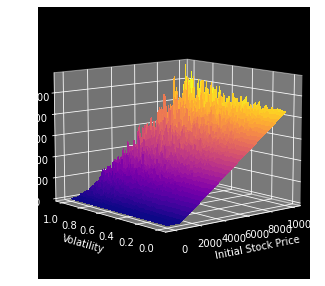

In [47]:
# Field grids

initial_stock_prices_grid, volatilities_grid = np.meshgrid(initial_stock_prices, volatilities)

# 3D Plot

ELEVATION = 10
INITIAL_AZIMUTH = 230

fig, ax = plt.subplots(figsize=(5, 5),
                       subplot_kw={"projection": "3d"})

surface = ax.plot_surface(initial_stock_prices_grid,
                          volatilities_grid,
                          option_prices_meshgrid.T,
                          cmap='plasma',
                          linewidth=30, 
                          antialiased=False)

ax.view_init(elev=ELEVATION, azim=INITIAL_AZIMUTH)


# ax.locator_params(axis='x', nbins=5)

ax.zaxis.set_rotate_label(False)

ax.set_xlabel('Initial Stock Price')
ax.set_ylabel('Volatility')
ax.set_zlabel('Option Price', rotation=90)

plt.show()

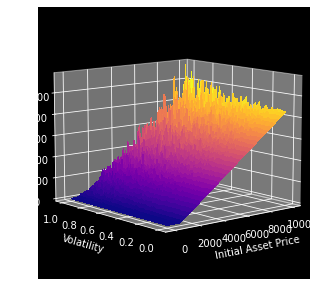

In [48]:
plot_asset_prices(initial_stock_prices, volatilities, option_prices_meshgrid)

In [50]:
option_prices_meshgrid[::10, ::10]

array([[    0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ],
       [    0.        ,    26.15654571,    48.50442661,   120.0665894 ,
          150.26344341,   106.46495908,   195.58802238,   206.22235769,
          246.72218076,   314.30581594,   287.53425581],
       [  922.26017569,   918.42459509,   929.7093806 ,  1007.61852039,
          979.03558781,   802.49988926,  1008.10584711,  1003.29642399,
          866.456165  ,  1057.47816436,   949.72786277],
       [ 1873.4896002 ,  1840.01709198,  1875.88978247,  1843.23003801,
         1708.0091    ,  2021.58402983,  1973.551627  ,  1988.8383621 ,
         2207.697145  ,  2086.93127605,  2124.29843511],
       [ 2824.7190247 ,  2839.39155774,  2818.7029314 ,  2799.58771704,
         2849.37971011,  3259.17149838,  2653.93954067,  2553.8720439 ,
         2414.4636056 ,  2523.2759425 ,  2787.829481

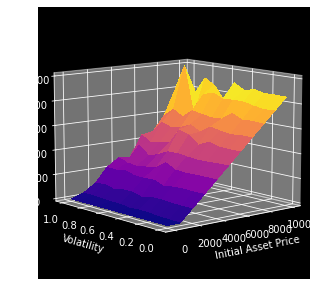

In [51]:
plot_asset_prices(initial_stock_prices, volatilities, option_prices_meshgrid[::10, ::10])